In [ ]:
import torch
import torch.nn as nn

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w

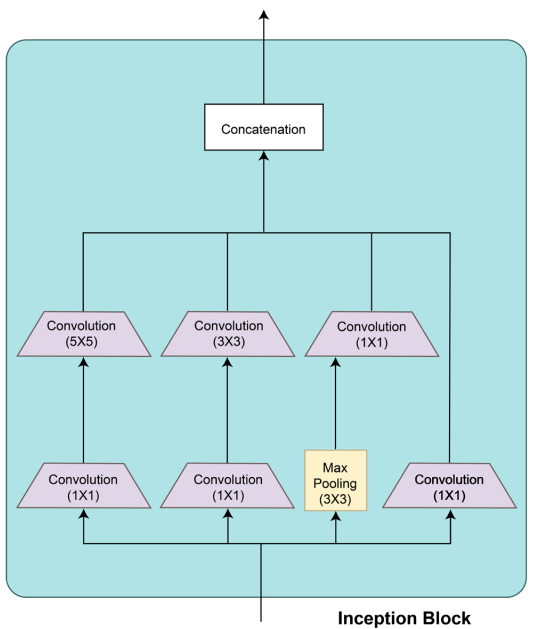

In [ ]:
class InceptionModule(nn.Module):
    def __init__(self, input_planes, n_channels1x1, n_channels3x3red, n_channels3x3, n_channels5x5red, n_channels5x5, pooling_planes):
        super(InceptionModule, self).__init__()
        # 1x1 convolution branch
        self.block1 = nn.Sequential(
            nn.Conv2d(input_planes, n_channels1x1, kernel_size=1),
            nn.BatchNorm2d(n_channels1x1),
            nn.ReLU(True),
        )
 
        # 1x1 convolution -> 3x3 convolution branch
        self.block2 = nn.Sequential(
            nn.Conv2d(input_planes, n_channels3x3red, kernel_size=1),
            nn.BatchNorm2d(n_channels3x3red),
            nn.ReLU(True),
            nn.Conv2d(n_channels3x3red, n_channels3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_channels3x3),
            nn.ReLU(True),
        )
 
        # 1x1 conv -> 5x5 conv branch
        self.block3 = nn.Sequential(
            nn.Conv2d(input_planes, n_channels5x5red, kernel_size=1),
            nn.BatchNorm2d(n_channels5x5red),
            nn.ReLU(True),
            nn.Conv2d(n_channels5x5red, n_channels5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_channels5x5),
            nn.ReLU(True),
            nn.Conv2d(n_channels5x5, n_channels5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_channels5x5),
            nn.ReLU(True),
        )
 
        # 3x3 maxpool -> 1x1 conv branch
        self.block4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(input_planes, pooling_planes, kernel_size=1),
            nn.BatchNorm2d(pooling_planes),
            nn.ReLU(True),
        )
 
    def forward(self, ip):
        op1 = self.block1(ip)
        op2 = self.block2(ip)
        op3 = self.block3(ip)
        op4 = self.block4(ip)
        return torch.cat([op1,op2,op3,op4], 1)

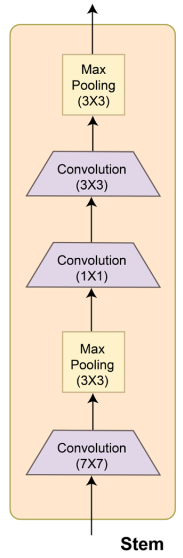

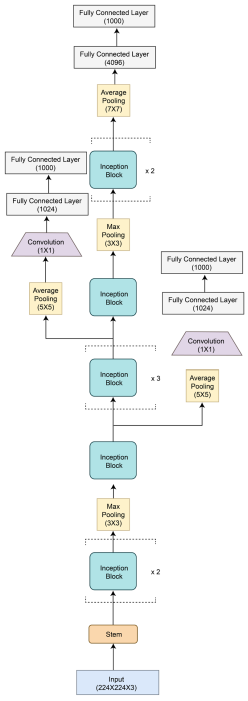

In [ ]:
class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )
        # input_planes, n_channels1x1, n_channels3x3red, n_channels3x3, n_channels5x5red, n_channels5x5, pooling_planes
        self.im1 = InceptionModule(192,  64,  96, 128, 16, 32, 32)
        self.im2 = InceptionModule(256, 128, 128, 192, 32, 96, 64)
 
        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)
 
        self.im3 = InceptionModule(480, 192,  96, 208, 16,  48,  64)
        self.im4 = InceptionModule(512, 160, 112, 224, 24,  64,  64)
        self.im5 = InceptionModule(512, 128, 128, 256, 24,  64,  64)
        self.im6 = InceptionModule(512, 112, 144, 288, 32,  64,  64)
        self.im7 = InceptionModule(528, 256, 160, 320, 32, 128, 128)
 
        self.im8 = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.im9 = InceptionModule(832, 384, 192, 384, 48, 128, 128)
 
        self.average_pool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(4096, 1000)
 
    def forward(self, ip):
        op = self.stem(ip)
        out = self.im1(op)
        out = self.im2(op)
        op = self.maxpool(op)
        op = self.a4(op)
        op = self.b4(op)
        op = self.c4(op)
        op = self.d4(op)
        op = self.e4(op)
        op = self.max_pool(op)
        op = self.a5(op)
        op = self.b5(op)
        op = self.avgerage_pool(op)
        op = op.view(op.size(0), -1)
        op = self.fc(op)
        return op

In [1]:
import torchvision.models as models
model = models.inception_v3(pretrained=True)
print(model)

/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /home/mb600l/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:09<00:00, 11.6MB/s] 

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri